DS256, Gettysburg College, Professor Eatai Roth

Oct 25, 2023

# Bias, Variance, and Regularization

The rule of thumb is that simpler models are preferable. However, a model that is too simple won't do a good job approximating the trends in the data. 

*Underfitting* refers to the selection of a model structure that is too simple to usefully describe trends in the data. 

In contrast, *overfitting* refers to models that are too complex, models that mistake randomness in a sample of data as trends. 

We want to hit a sweet spot, choosing an appropriate model that is neither under- or over-fit. But how?

## The Bias-Variance Problem

The rule of thumb is that simpler models are preferable. This guiding principle is a summary (possibly an over-simplification) of the Bias-Variance tradeoff.

Bias and variance refer to two sources of error that arise in fitting machine learning models.

*Bias error* are errors in model fit. Typically, bias results from using a model that is too simple to capture the relationships in the data, namely *under-fitting*.

*Variance* refers to errors that arise from models that capture the specific fluctuations or noise in the training data that don't generalize to other data. Using such a model that is too complex and hence to specific to the training data, is called *over-fitting*.

## Symptoms of Under- and Over-fitting

**Under-fitting**
- High bias (fitting or classification error) in both training and testing sets.
- Model doesn't "look like" data (this is really only apparent for simple models).

**Over-fitting**
- Low bias in training data and significant drop off in testing. The model doesn't generalize.
- If the model is re-fit using different samples for training, the model parameters will change dramatically. This is the underlying principle of a model selection method called cross-validation.


## Regularization

When we explored Multiple Linear Regression, we tried to select features by inspecting correlations between a feature and the target as well as between features. But how did we know if we were using the right features and the right number of features? We didn't.

*Regularization* is a tool for automatically emphasizing the features that are informative as you fit the model. Recall, in fitting linear regression models, we are minimizing the mean-squared error between our predictions and the true values. The cost function has the form:

$$
C(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^n(y_i - \hat{y}_i)^2
$$

Regularization adds a term to the cost function that penalizes large feature weights ($w_i$). Two common regularization algorithms are:

 - Ridge regression:

 $$
C_ridge(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^n(y_i - \hat{y}_i)^2 + \alpha \underbrace{\sum_{i=0}^n ||w_i||_2}_{\text{penalty on L2 norm of weights}}
$$

 - Lasso regression (Least Absolute Shrinkage and Selection Operator):

 $$
C_{lasso}(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^n(y_i - \hat{y}_i)^2 + \alpha \underbrace{\sum_{i=0}^n ||w_i||_1}_{\text{penalty on L1 norm of weights}}
$$

Where 
 - $\alpha$ is a hyper-parameter that balances how much you want to balance model simplification and model fit.
 - L2 norm is the sum of squared values of weights
 - L1 norm is the sum of the absolute values of weights

That Ridge uses the L2-norm and Lasso uses the L1-norm can be reduced to the following observation:
 - Ridge regression will make some weights small, but not zero. This is useful if you believe many of the features contribute to the model.
 - Lasso regression will drive some weights to zero. This is useful if you believe only a few weights contribute.

 However, we generally don't know in advance how our features will contribute to the model, so best to try both and compare.








## Example

In the below example, we'll be fitting a model to noisy data. The underlying equation of the model is a polynomial, but doesn't include every power of x.

$$
y_{ideal} = -4 x^8 - x^5 + 3x^2 -1
$$

Even though the model is polynomial with degree 8, there are only 4 coefficients represented. We could fit a polynomial regression to the data, but we won't get the right subset of powers. Let's see how we do though.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

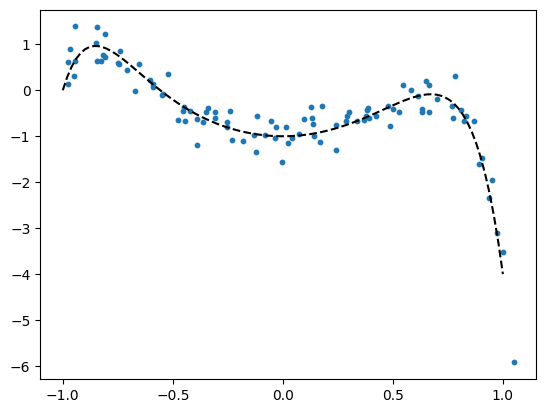

In [2]:
num_samples = 100

poly_coeff = [-4, 0, 0, -2, 0, 0, 3, 0, -1]
my_poly = lambda z: np.polyval(poly_coeff, z) #-4*z**8 - 1*z**5 + 3*z**2 - 1

x = np.sort(np.linspace(-1,1,num_samples) + np.random.normal(loc=0, scale=0.05, size=num_samples))
y = my_poly(x) + np.random.normal(loc = 0, scale = 0.3, size = num_samples)

x_range = np.linspace(-1,1,100).reshape(-1,1)
y_range = my_poly(x_range)

plt.scatter(x, y, s=10)
plt.plot(x_range, y_range, 'k--')
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, test_size = 0.5)

degs = [1, 2, 4, 8, 16]

models = {}

for deg in degs:

    poly = PolynomialFeatures(degree=deg)
    X_train = poly.fit_transform(x_train)
    X_test = poly.transform(x_test)

    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)


    reg_poly = LinearRegression()
    reg_poly.fit(X_train_scaled, y_train)

    x_model = ss.transform(poly.transform(x_range))
    y_model = reg_poly.predict(x_model)

    R2_train = reg_poly.score(X_train_scaled, y_train)
    R2_test = reg_poly.score(X_test_scaled, y_test)

    models[deg] = dict(
        title = f'Poly {deg}',
        scaler = ss,
        model = reg_poly,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )



In [4]:
from sklearn.linear_model import Lasso, Ridge
lasso_poly = Lasso(alpha = 0.01)
lasso_poly.fit(X_train_scaled, y_train)

y_model = lasso_poly.predict(x_model)

R2_train = lasso_poly.score(X_train_scaled, y_train)
R2_test = lasso_poly.score(X_test_scaled, y_test)

models['lasso'] = dict(
        title = f'Lasso',
        scaler = ss,
        model = lasso_poly,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )

ridge_poly = Ridge(alpha = 5)
ridge_poly.fit(X_train_scaled, y_train)

y_model = ridge_poly.predict(x_model)

R2_train = ridge_poly.score(X_train_scaled, y_train)
R2_test = ridge_poly.score(X_test_scaled, y_test)

models['ridge'] = dict(
        scaler = ss,
        title = f'Ridge',
        model = reg_poly,
        y_model = y_model,
        R2_train = R2_train,
        R2_test = R2_test
    )

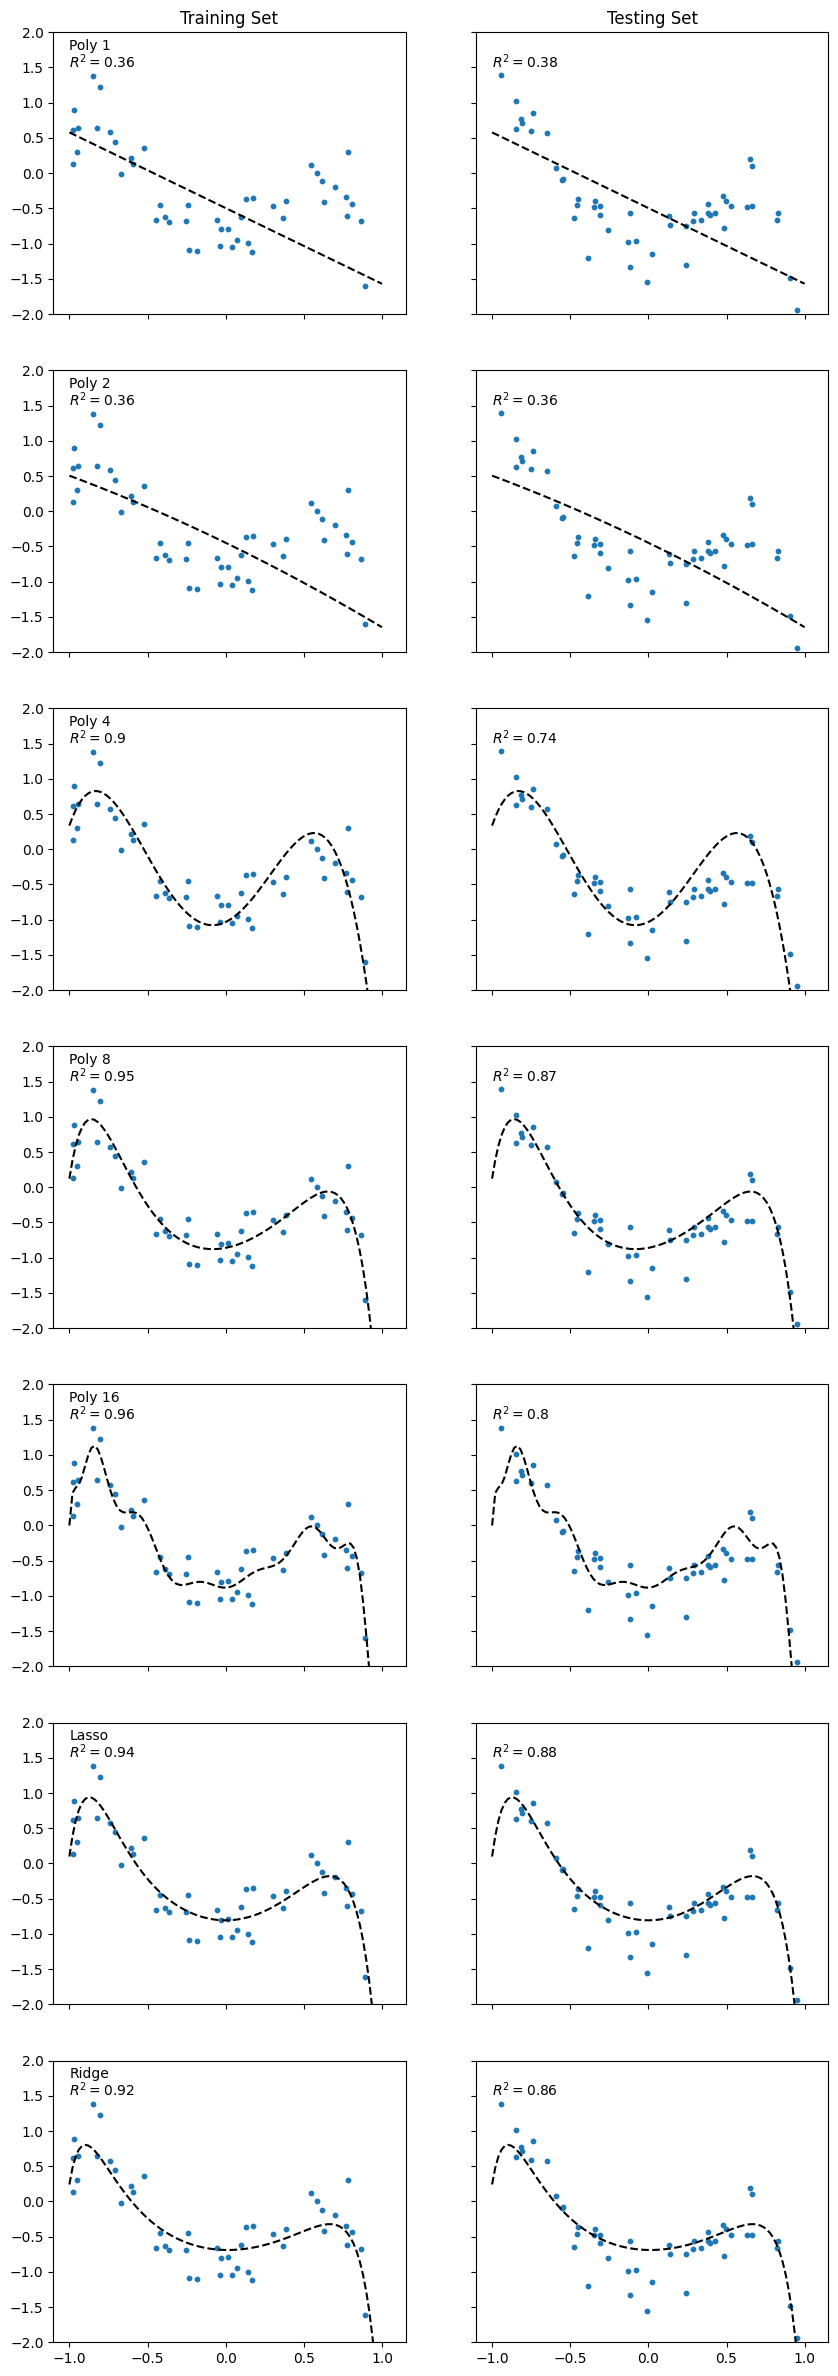

In [5]:
fig,ax = plt.subplots(len(models), 2, figsize = (10,30), sharex=True, sharey=True)

x_range = np.linspace(-1,1,100).reshape(-1,1)
y_true = my_poly(x_range)

for k, key in enumerate(models):
    reg = models[key]

    ax[k,0].scatter(x_train, y_train, s=10)
    ax[k,0].plot(x_range, reg['y_model'], 'k--')
    ax[k,0].text(-1,1.75, reg['title'])
    ax[k,0].text(-1,1.5, f'$R^2 = ${reg["R2_train"]:.2}')


    ax[k,0].set_ylim(-2,2)

    ax[k,1].scatter(x_test, y_test, s=10)
    ax[k,1].plot(x_range, reg['y_model'], 'k--')  
    
    ax[k,1].text(-1,1.5, f'$R^2 = ${reg["R2_test"]:.2}')
    ax[k,0].set_ylim(-2,2)

ax[0,0].set_title('Training Set')
ax[0,1].set_title('Testing Set')
plt.show()



In [6]:
coeff_df = pd.DataFrame()
nans = ['']*17
coeff_df['True'] = nans
coeff_df['True'].iloc[np.arange(len(poly_coeff))] = poly_coeff

for key in models:
    
    reg = models[key]
    title = reg['title']
    
    coeffs = reg['model'].coef_
    coeffs[0] = reg['model'].intercept_

    coeff_df[title] = nans
    coeff_df[title].iloc[np.arange(len(coeffs))] = np.round(coeffs,1)

coeff_df

/var/folders/qm/g7x838zs775f4j_5s231csf80000gn/T/ipykernel_47307/2613986131.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  coeff_df['True'].iloc[np.arange(len(poly_coeff))] = poly_coeff
/var/folders/qm/g7x838zs775f4j_5s231csf80000gn/T/i

,True,Poly 1,Poly 2,Poly 4,Poly 8,Poly 16,Lasso,Ridge
0,-4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
1,0,-0.7,-0.7,0.7,0.3,0.1,0.0,0.1
2,0,,-0.0,2.0,0.8,3.2,0.7,3.2
3,-2,,,-1.4,-0.6,6.2,-0.0,6.2
4,0,,,-2.2,0.2,-66.1,-0.0,-66.1
5,0,,,,-0.2,-64.5,-0.8,-64.5
6,3,,,,-0.1,618.8,-0.0,618.8
7,0,,,,-0.2,277.1,-0.0,277.1
8,-1,,,,-1.2,-2680.2,-0.2,-2680.2
9,,,,,,-648.8,-0.0,-648.8
